In [32]:
import os
import shutil
import glob
import SimpleITK as sitk
import six
import radiomics
import getopt
import sys
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import json
# importing the zipfile module
import nibabel as nib
import numpy as np
#libraries
import shutil
from collections import OrderedDict
import json
import numpy as np
import pandas as pd

#visualization of the dataset
import matplotlib.pyplot as plt
import nibabel as nib
from operator import itemgetter
import os
base_dir = "/home/hrehman/"


BASE_PATH = "/data4/hrehman/Clinical_Data/"
BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
INPUT_FOLDER = BASE_PATH + '3-13-2023/'

In [2]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f'{folder_path} exists.')
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

In [3]:
task_name = 'Task101_SCGM' #change here for different task name
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [4]:
make_if_dont_exist(task_folder_name,overwrite = False)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir,overwrite= False)
make_if_dont_exist(os.path.join(main_dir,'nnunet_trained_models'))

nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/imagesTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/labelsTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/imagesTs exists.
/home/hrehman/nnUNet/nnunet/nnunet_trained_models exists.


# Environment Variables

In [5]:
main_dir = "/home/hrehman/nnUNet/nnunet/"
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

# Data Conversion

At this point i have to convert the data in such way that all the CT are compiled in one file and all the segmentation of the ground truth should be equal to the actual size of the CT slices.

### Loading the patinets

In [6]:
patients = os.listdir(INPUT_FOLDER)
patients.sort()

### Creating the Configuration for the right order of CT with segmentation

In [7]:
def last_4chars(x):
    return(x[-1:])

def sort_dcm_files_CT(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
    path = INPUT_FOLDER + patient + '/CT/'
    list_of_files = os.listdir(path)
    # for specific cases like the patinets in the above cell you can see they have different file formate, in order to fix this we have to perform sorting on the second part of the filename
    # this line is for sorting on first part of the -
    list_of_files = sorted(list_of_files, key=lambda x: int(x.split("-")[0]))
    # this line is for sorting on second part of the - for the patinets that are above mentioned
    # list_of_files = sorted(list_of_files, key=lambda x: int(str(x.split("-")[1]).split(".")[0]))
    return list_of_files
def get_SEG(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
    path = INPUT_FOLDER + patient + '/SEG/'
    file = os.listdir(path)
    return file

def get_reference_segmnetation(ds):
    reference_CT = ds[0x0008, 0x1115][0][0x0008, 0x114a]
    return reference_CT

this function create the config file for each sample to determine the location of Segmentation corresponding to the CT scan

In [8]:
def create_config():
        for patient in patients:
            print(patient)

            ## Get the CT scan first and create a sorted list with all the information
            CT_info = []
            CT_files = []
            path = INPUT_FOLDER + patient + '/CT/'
            files = sort_dcm_files_CT(patient=patient)
            for file in files:
                CT_files.append(dcmread(os.path.join(path,file)))
            for slice in CT_files:
                CT = {"UID" : None,
                    "file" : None,
                    "Location": None,
                    "pixels" : None}
                CT['UID'] =  slice[0x0008, 0x0018].value
                CT['Location'] =  slice[0x0020, 0x1041].value
                CT['pixels'] =  slice.pixel_array
                CT_info.append(CT)
            CT_info = sorted(CT_info, key=itemgetter('Location'))
            
            ## Now we will get the segmentation:
            segmentaion_dict = {}
            seg_ids = []
            #get a patient segmentation
            file = os.listdir(INPUT_FOLDER + patient + '/SEG')
            path = INPUT_FOLDER + patient + '/SEG/'

            #Read the segmentation and get the reference CT of it
            SEG = dcmread(os.path.join(path,file[0]))
            SEG_pixel_array = SEG.pixel_array
            segmentations = get_reference_segmnetation(SEG)
            new_image_data = np.zeros((512,512,len(files)),dtype="int16")
            #populate the dictionary with the values of segmentation as 0,1,2 ....
            for i,seg in enumerate(segmentations):
                        seg_ids.append(str(seg[0x0008, 0x1155].value))
                        segmentaion_dict[i] = ''

            for i,ct_item in  enumerate(CT_info):
                if str(ct_item['UID']) in seg_ids:
                    for j,v in enumerate(seg_ids):
                                # print(j,v)
                                if v == str(ct_item['UID']):
                                    # for all the patinets 
                                    # where J is the position of segmentation in segmentation file and i is the corresponding to the CT scan position
                                    segmentaion_dict[j] = i
            print(segmentaion_dict)
            with open( BASE_PATH + "Nifti/config(full)/" + patient + ".txt", 'w') as f: 
                # for key, value in segmentaion_dict.items(): 
                #     f.write('%s:%s\n' % (key, value))
                json.dump(segmentaion_dict,f)

In [9]:
'''This function will basically create a corresponding file of each mask location(key) , to the actual location according to the CT scans (value)'''
# create_config() 

'This function will basically create a corresponding file of each mask location(key) , to the actual location according to the CT scans (value)'

here we need the conversion of the dicm files directly to nii file without worrying about the postion of the segmentaion , that is already reserved in full configuration folder, where key is the position of segmentaion and the value is the slide location

Lets say that i have "1" :25 ,  this means that 1 is the slice location of segmentation and 25 is the CT scan slice location where slice '1' segmentation belongs


in much simpler words , the the key tells the slice number of segmentation and value tells where this slice should be according to the CT scan.

### conversion of CT's from dicom to nii.gz

In [10]:
def convertCTFiles():
    count = 0
    for patient in patients:
                print(patient)
                path = BASE_PATH + "/nii_for_automated_segmentation/CT/"
                name = 'R' + str(int(patient.split('-')[1]))
                files = os.listdir(INPUT_FOLDER + patient + '/CT/')
                print(name)
                dicom_list = [pydicom.read_file(os.path.join(INPUT_FOLDER + patient + '/CT/', f)) for f in files]
                dicom2nifti.convert_dicom.dicom_array_to_nifti(dicom_list,os.path.join(path, str(name)+ '_0000.nii.gz'),reorient_nifti=False)

In [11]:
# convertCTFiles()

### arranging segmentations wrt configuration

In [12]:
def mask_conversion():
                count = 0 
                # config_patinets = ["R01-020.txt","R01-049.txt","R01-052.txt","R01-056.txt","R01-075.txt","R01-090.txt","R01-098.txt"]
                config_patinets = os.listdir(BASE_PATH + "Nifti/config(full)")
                len(config_patinets)
                for patient in patients:
                    print(patient)
                    count+=1
                    if str(patient+'.txt') in config_patinets:
                        path = BASE_PATH + "Nifti/" + patient
                        # Load the original NIfTI file
                        nii_file = nib.load(path  + '/SEG/'+ "1.nii")
                        CT_file = nib.load(path + '/CT/'+ "output.nii")

                        # Get the image data as a Numpy array
                        mask_data = nii_file.get_fdata()
                        
                        # reading the data from the file
                        with open(BASE_PATH + 'Nifti/config(full)/'+patient+'.txt',"r") as f:
                            config =  json.load(f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
                        # Define the dictionary that specifies the slice order
                        slice_order = config
                        
                        # Create a new Numpy array to hold the reordered slices
                        # new_image_data = np.zeros((512,512,len(config)),dtype="int16")
                        new_mask_data = np.zeros(CT_file.shape,dtype="int16")

                        # Loop through the dictionary and copy each slice to its new position
                        for old_idx, new_idx in slice_order.items():
                            new_idx = int(new_idx)
                            old_idx = int(old_idx)
                            new_mask_data[:, :, new_idx] = mask_data[:, :, old_idx]

                        # Create a new NIfTI file with the reordered slices
                        new_nii_file = nib.Nifti1Image(new_mask_data, nii_file.affine, header=nii_file.header)
                        path = BASE_PATH + "nii_for_automated_segmentation/GT_SEG/"
                        name = 'R' + str(int(patient.split('-')[1]))
                        # Save the new NIfTI file
                        nib.save(new_nii_file, path + name + ".nii.gz")
                print(count , "Patients CT data was cleaned with relavent segmentations")

In [13]:
# mask_conversion()

# Predictions

At this point the segmentation and the CT both are in the form of as a requirement for the prediction by nnUNet
The below function removes the CT scans from the main folder which is required for prediction inorder to avoid the case of already predicted samples

In [14]:
def remove_done_prediction_files():
        '''This function here is intended to remove the CT files from the main folder if they are already predicted'''
        done_predictions = os.listdir('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet')
        done_patients = []
        for pred in done_predictions:
            done_patients.append((pred).split(".")[0])
        done_patients = np.unique(done_patients)
        for patient in done_patients:
            if str(patient).startswith("R"):
                name = patient + "_0000.nii.gz"
                source = "/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/CT/" + name
                destination =  "/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/CT_Done/" + name
                if os.path.exists(destination) == False:    
                    shutil.move(source, destination)
remove_done_prediction_files()

check how many are predicted

In [15]:
(len(os.listdir("/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet"))-4)/3

138.0

Check how many done with the predict command

In [16]:
len(os.listdir("/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/CT_Done"))

138

### Predict command for nnUNet

In [17]:
!nnUNet_predict -i "/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/CT" -o "/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet/" -t 6 --save_npz -m 3d_fullres -f 4



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



using model stored in  /home/hrehman/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task006_Lung/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Traceback (most recent call last):
  File "/home/hrehman/radiomics_venv/bin/nnUNet_predict", line 8, in <module>
    sys.exit(main())
  File "/home/hrehman/radiomics_venv/lib/python3.10/site-packages/nnunet/inference/predict_simple.py", line 219, in main
    predict_from_folder(model_folder_name, input_folder, output_folder, folds, save_npz, num_threads_preprocessing,
  File "/home/hrehman/radiomics_venv/lib/python3.10/site-packages/nnunet/inference/predict.py", line 636, in predict_from_folder
    case_ids = check_input_folder_and_return_caseIDs(input_folder, expected_num_modalities)
  File "/home/hrehman/radiomics_venv/lib/python3.10/site-packages/nnunet/inference/predict.py", line 577, in check_input_folder_and_return_caseIDs
    assert len(files) > 0, "input folder did not contain any images (ex

# Visualizations

#### Predicted

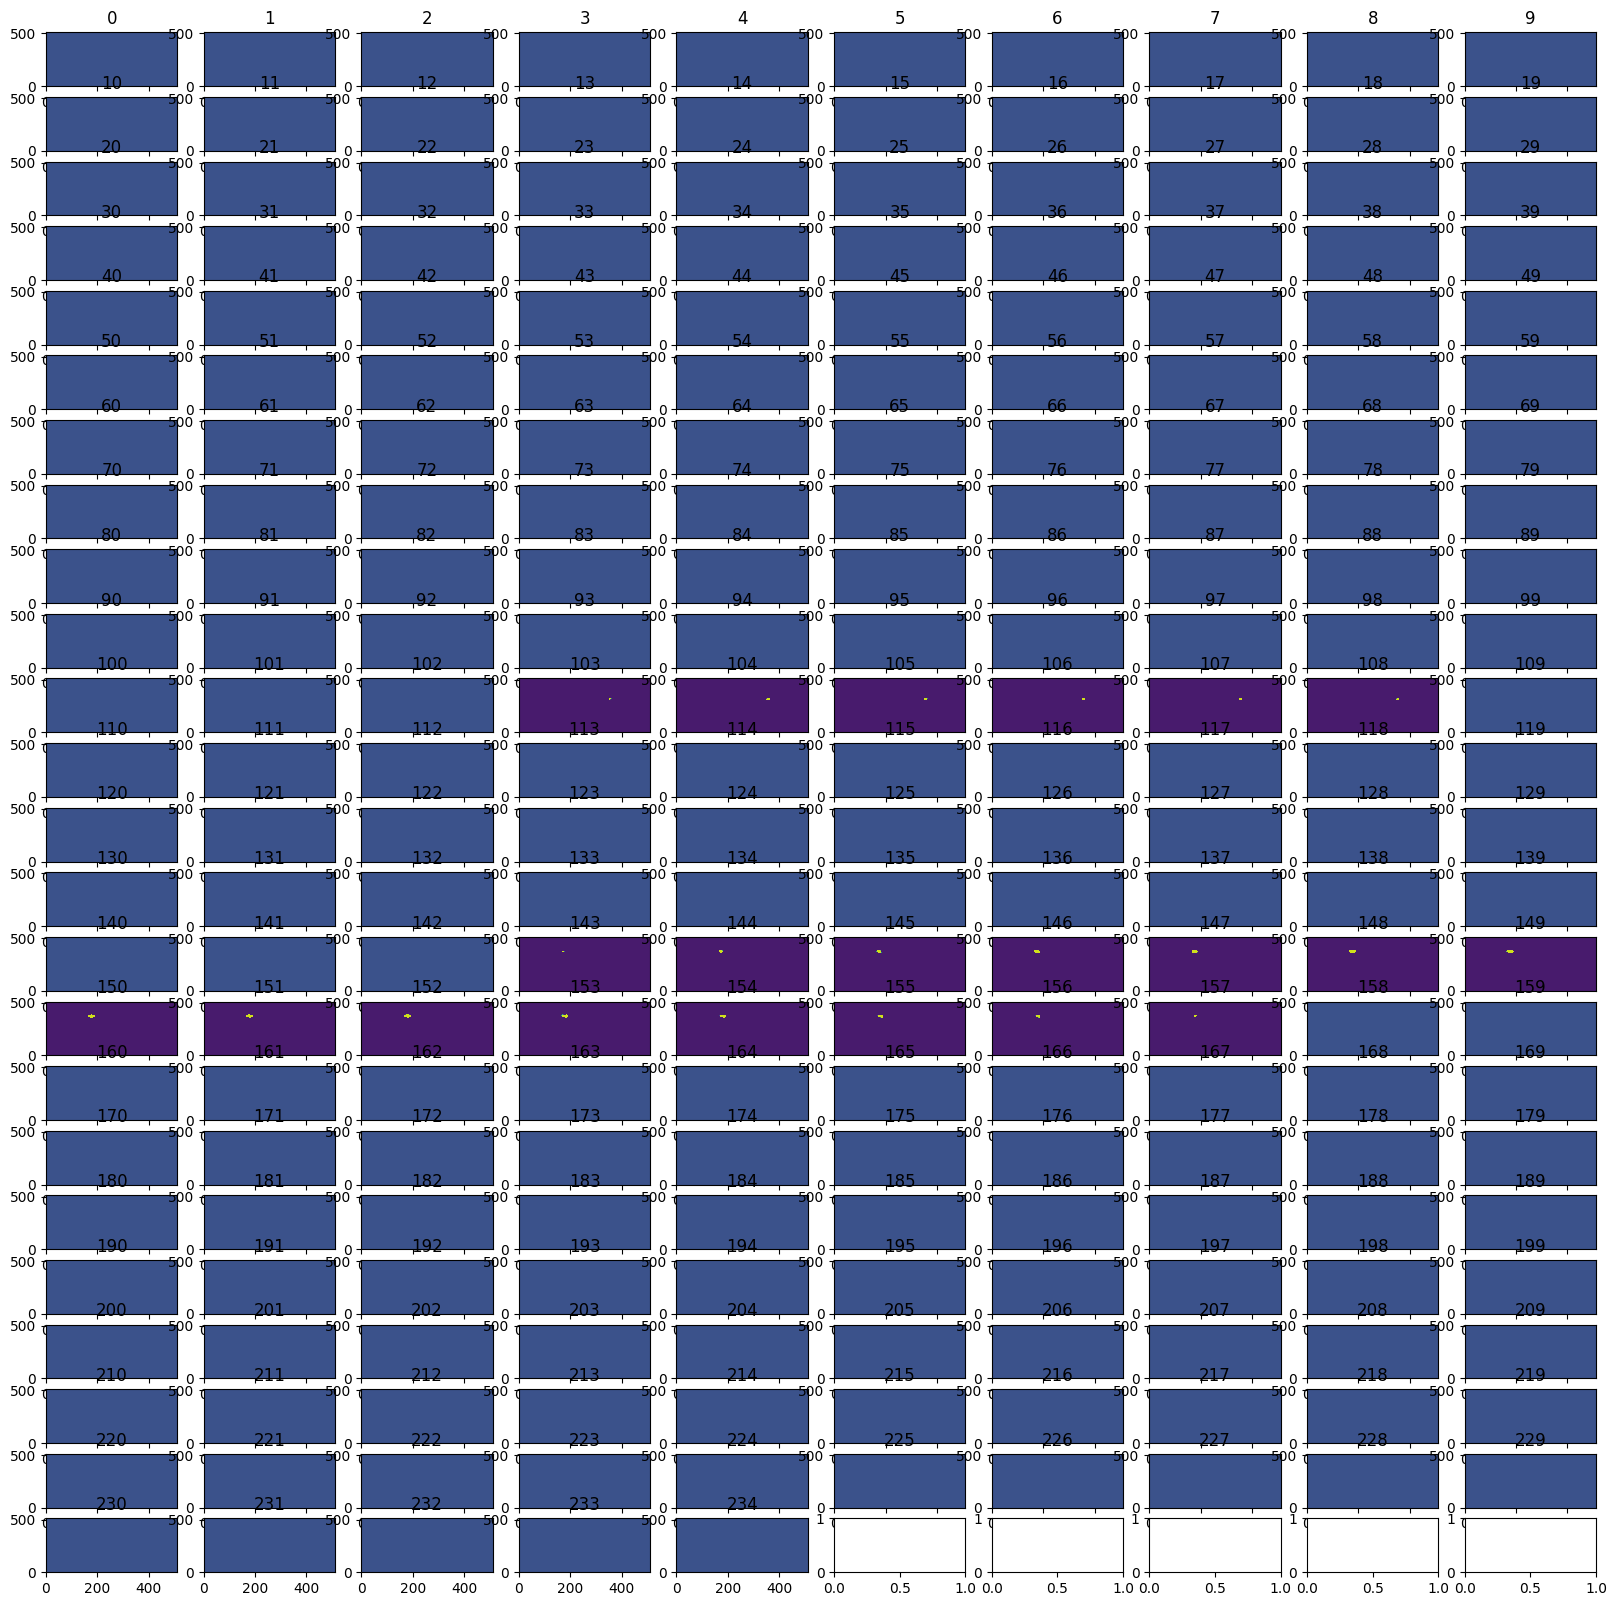

In [18]:
test_load = nib.load('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet/R33.nii.gz').get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')

# fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(235):
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)

#### Ground-Truth

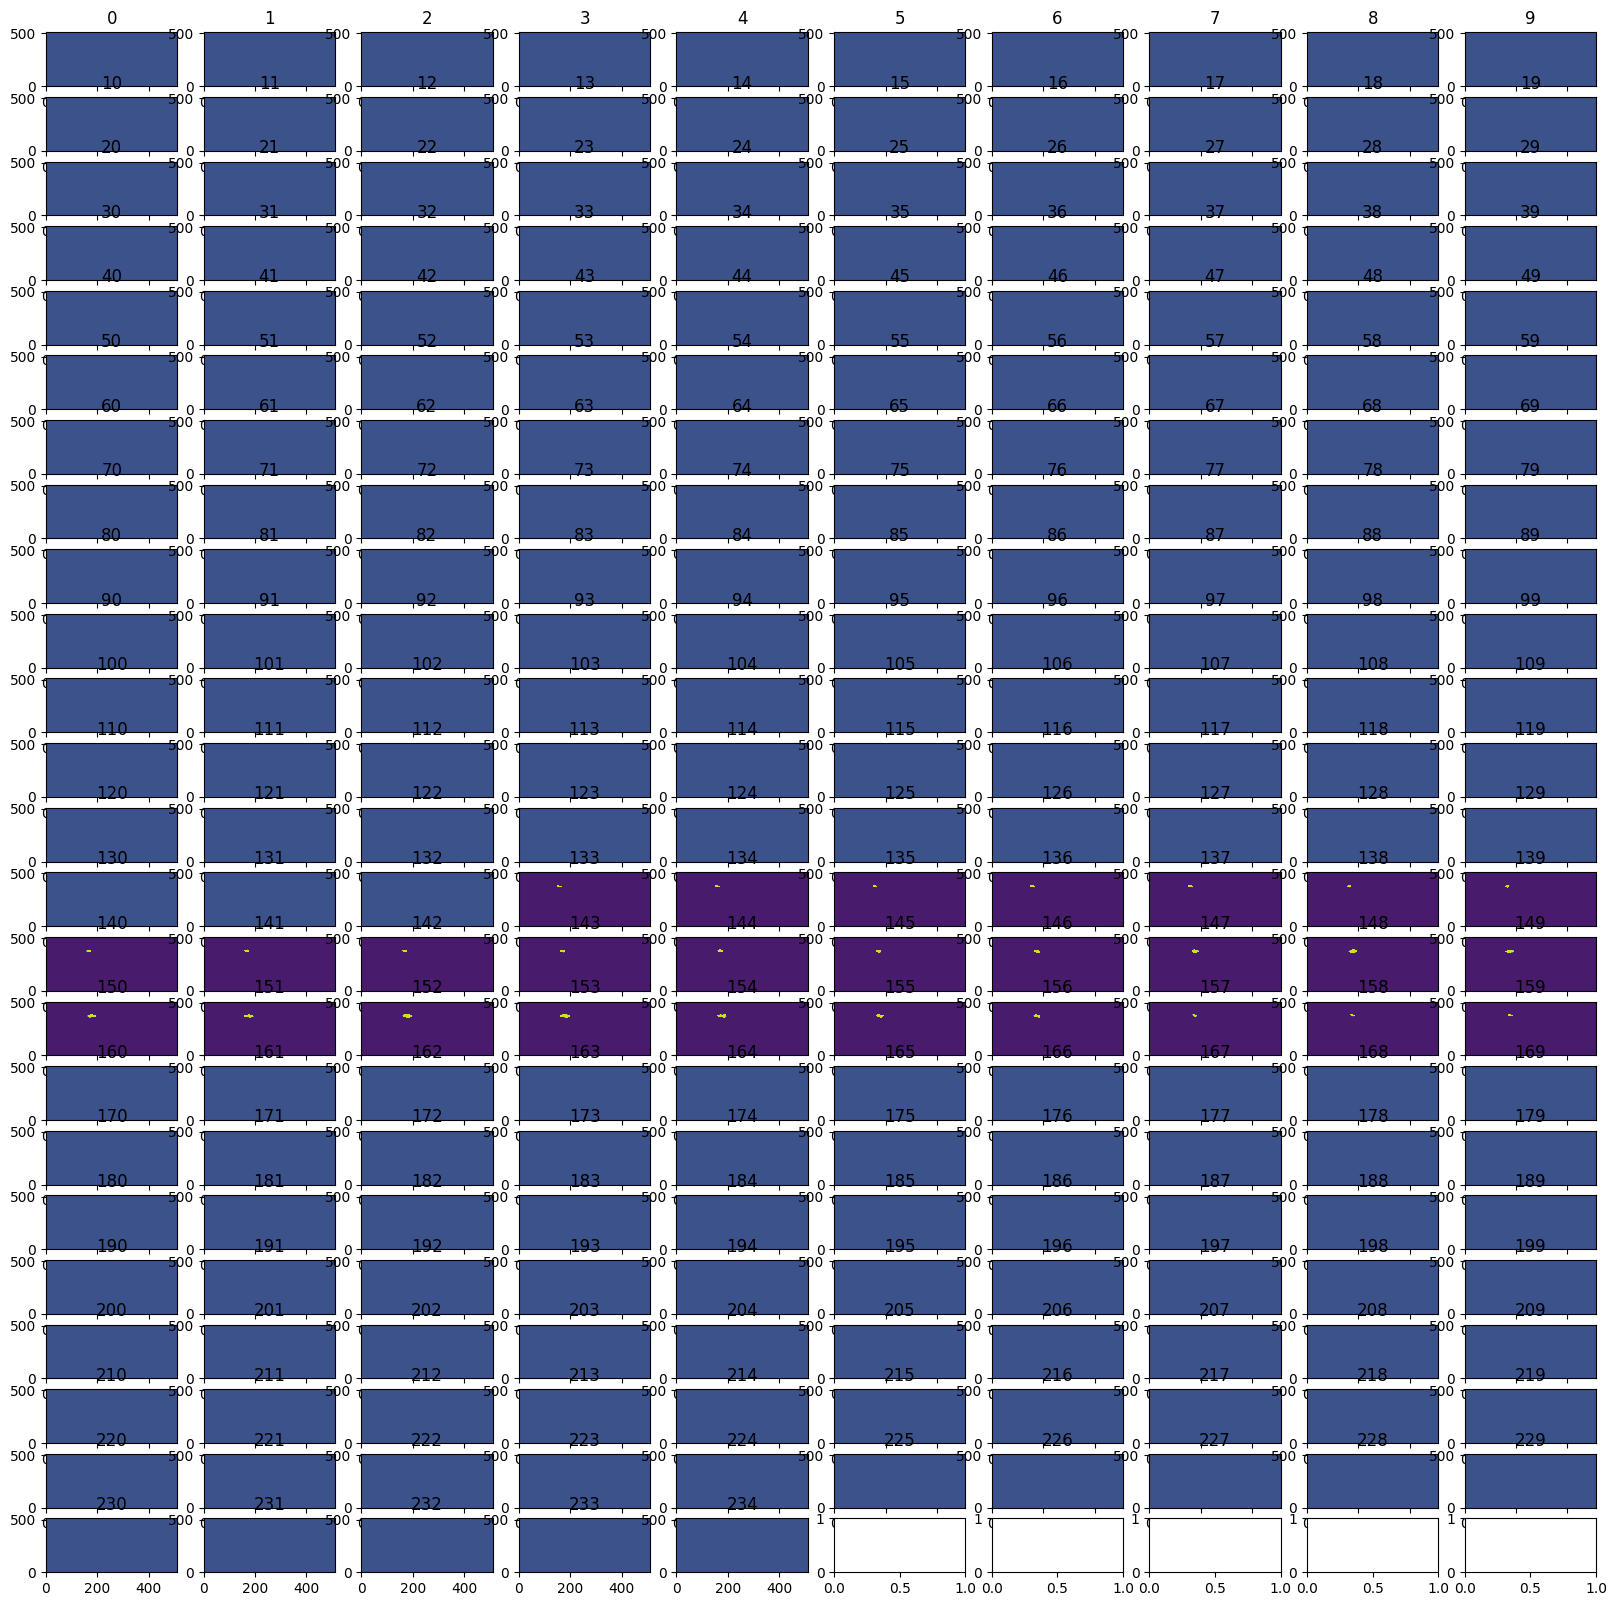

In [19]:
test_load = nib.load('/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/GT_SEG/R33.nii.gz').get_fdata()
test_load.shape
fig, axs = plt.subplots(24,10, figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
# plt.imshow(test_load[:,:,141],cmap='gray')
axs = axs.ravel()

for i in range(235):
    # axs[i].contourf(test_load[:,:,i])
    axs[i].contourf(test_load[:,:,i])
    axs[i].set_title(i)

Now that we have the prediction from the nnunet , we will try to visualize it with start and end of the mask logic

In [20]:
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [21]:

def findStart(SEG):
    start = True
    count = len(SEG)
    startval = 0
    i = 0
    #Running Array into the forward direction to find start of segmentation set
    for img in SEG:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and start==True:
                start = False
                startval = i
                break
        i+=1
    return startval
def findEnd(SEG):
    end = True
    #Running Array into the backwards direction to find end of segmentation set
    i = len(SEG) -1
    count = 0
    endval = 0
    # SEG_rev = SEG[:, :, ::-1]
    SEG_rev  =np.flip(SEG, axis=None)
    # print(SEG_rev)
    for img in SEG_rev:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and end==True:
                end = False
                endval = i
                break
        i-=1
    return endval

In [82]:
patients = ['R01-080']  # Just for the patinet 33

In [83]:
for patient in patients:
    # if str(patient+'.txt') in config_patinets:
        # print(patient)
        with open(BASE_PATH + 'Nifti/config(full)/'+patient+'.txt',"r") as f:
            config =  json.load(f)
            # print(len(config))
        path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
        name = 'R' + str(int(patient.split('-')[1]))

        # This is for the groundtruth segmentation
        Segmentations = sitk.ReadImage("/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/GT_SEG/" + name +".nii.gz")
        
        SEG = sitk.GetArrayFromImage(Segmentations)
        
        #find start and end of the segmentation slices of the ground truth
        (gt_start) = findStart(SEG)
        (gt_end) = findEnd(SEG)

        # This is for the predicted segmentation
        Segmentations = sitk.ReadImage("/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet/" + name +".nii.gz")
        
        SEG = sitk.GetArrayFromImage(Segmentations)
        
        #find start and end of the segmentation slices of the prediction.
        (pred_start) = findStart(SEG)
        (pred_end) = findEnd(SEG)


In [84]:
import cv2
if gt_start < pred_start:
    start = gt_start
else:
    start = pred_start


if gt_end > pred_end:
    end = gt_end
else:
    end = pred_end

images_all = []
images_all_gt = []
images_all_pred = []
for count in range(start,end):
        
        in_image = nib.load('/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/CT_Done/R80_0000.nii.gz').get_fdata()
        image = in_image[:,:,count]
        # Convert 2D array to 3D array by adding a new axis
        # stacked_img = np.stack((image,)*3, axis=-1)

        # image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        image = np.repeat(image[..., np.newaxis], 3, axis=2)
        # image = np.array(image)
        # plt.imshow(image)
        # print(stacked_img.shape)



        in_gt_image = nib.load('/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/GT_SEG/R80.nii.gz').get_fdata()
        gt_image = in_gt_image[:,:,count]
        # plt.imshow(gt_image)
        # # create empty RGB image with same dimensions as binary image
        gt_rgb_image = np.zeros((image.shape[0], image.shape[1], 3),dtype="float64")

        # # set red color for all 1's in binary array
        # gt_rgb_image[gt_image == 1] = (255,0, 0)  # red color in BGR format
        # gt_rgb_image[gt_image > 0] = (255, 0, 0)  # Set masked pixels to red
        gt_rgb_image[..., 1] = gt_image * 255  # Green channel
        # plt.imshow(gt_rgb_image)


        in_pred_image = nib.load('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet/R80.nii.gz').get_fdata()
        pred_image = in_pred_image[:,:,count]

        # # create empty RGB image with same dimensions as binary image
        pred_rgb_image = np.zeros((image.shape[0], image.shape[1], 3),dtype="float64")

        # # set red color for all 1's in binary array
        # pred_rgb_image[gt_image == 1] = (0,255, 0)  # red color in BGR format
        pred_rgb_image[..., 0] = pred_image * 255  # Red channel

        # overlay_img = cv2.addWeighted(gt_rgb_image, 30,image, 2.5, 0)
        overlay_img = np.maximum(image, gt_rgb_image)
        images_all_gt.append(overlay_img)
        # images_all.append(cv2.addWeighted(pred_rgb_image, 30,overlay_img, 2.5, 0))
        images_all.append(np.maximum(overlay_img, pred_rgb_image))
        # overlay_img = cv2.addWeighted(pred_rgb_image, 30,image, 2.5, 0)
        overlay_img = np.maximum(image, pred_rgb_image)
        images_all_pred.append(overlay_img)
        print("Image Done : ", count)
    

Image Done :  152
Image Done :  153
Image Done :  154
Image Done :  155
Image Done :  156
Image Done :  157
Image Done :  158
Image Done :  159
Image Done :  160
Image Done :  161
Image Done :  162
Image Done :  163
Image Done :  164
Image Done :  165
Image Done :  166
Image Done :  167
Image Done :  168
Image Done :  169
Image Done :  170
Image Done :  171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

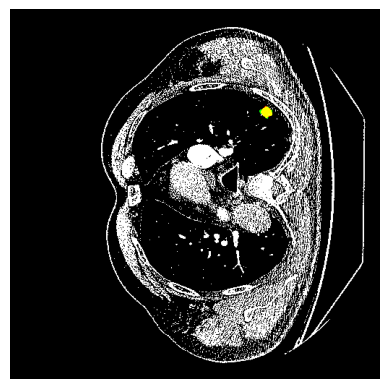

In [88]:

# Display the overlayed image
plt.imshow(images_all[11])
plt.axis('off')
# plt.show()

In [70]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming you have the 2-channel lung CT image and mask as numpy arrays
# lung_ct_image = in_image[:,:,148]
# mask = images_all[:,:,148]

# # Convert the 2-channel lung CT image to 3-channel (assuming Channel 1 is Red and Channel 2 is Green)
# lung_ct_image_3ch = np.repeat(lung_ct_image[..., np.newaxis], 3, axis=2)

# color_mask = np.zeros((512, 512, 3), dtype=np.float32)
# color_mask[..., 1] = mask * 255  # Red channel

# # Overlay the color mask on the lung CT image
# overlayed_image = np.maximum(lung_ct_image_3ch, color_mask)

# # Display the overlayed image
# plt.imshow(overlayed_image)
# plt.axis('off')
# # plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

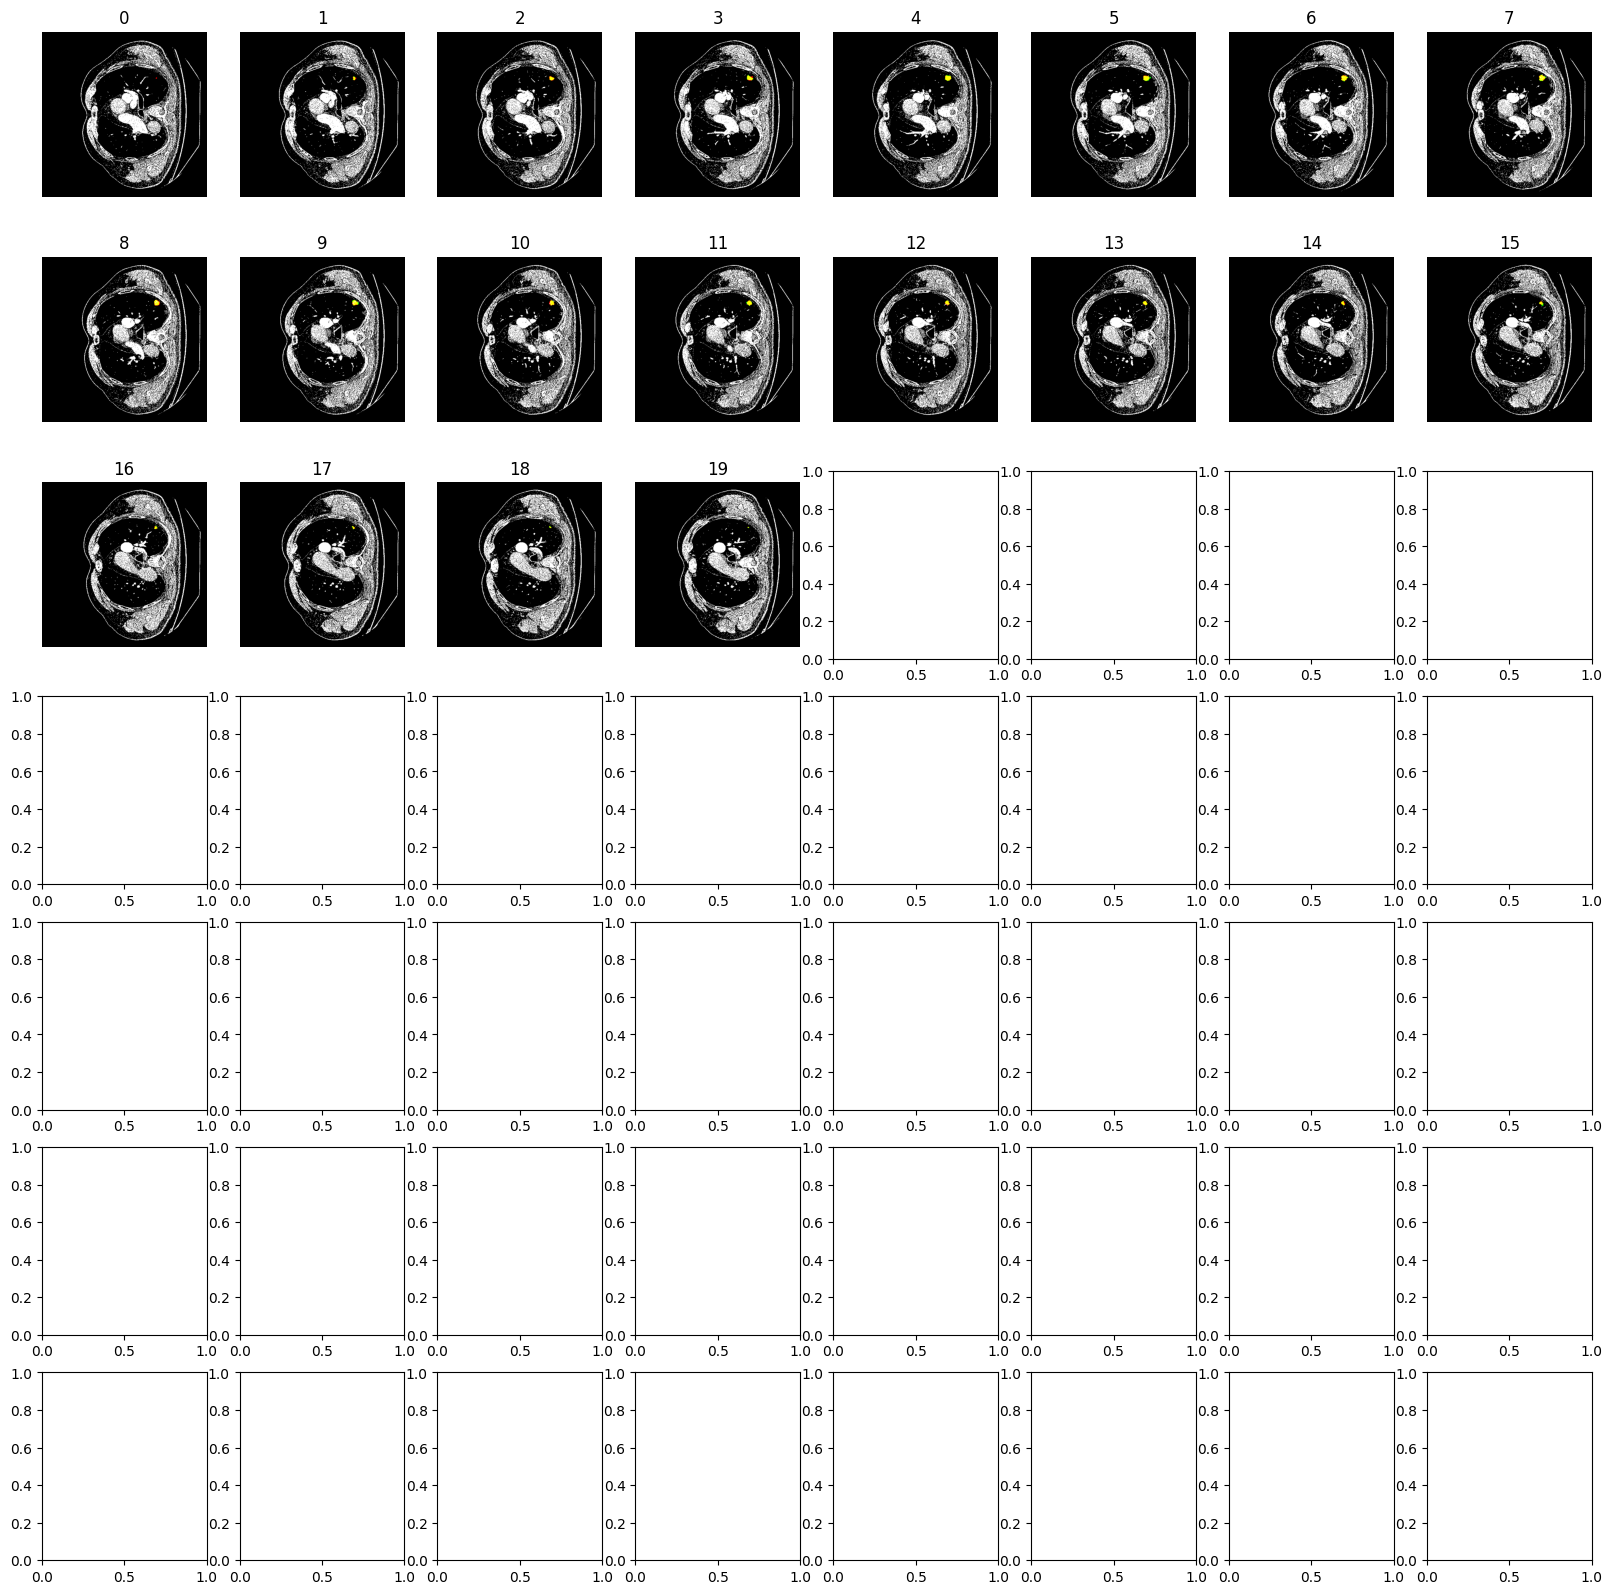

In [85]:
fig, axs = plt.subplots(7,8, figsize=(20,20), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(end-start):
  axs[i].imshow(images_all[i],cmap = 'gray')
  # axs[i].contourf(images_all[i])
  axs[i].set_title(i)
  axs[i].set_axis_off()
plt.grid(False)
plt.set_cmap('hot')
plt.axis("on")
plt.show()

# Evaluation

In [27]:
def copy_files_for_evaluation(patinet_name):
        '''This function here is intended to remove the CT files from the main folder if they are already predicted'''
        # predictions = os.listdir('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet')
        import os
        import glob

        files = glob.glob('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred//*')
        files = glob.glob('//home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/*')
        patinet_name =  "R" + str(int(str(patinet_name).split('-')[1]))
        if str(patinet_name).startswith("R"):
                
                name = patinet_name + ".nii.gz"
                source_pred = "/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/preds_nnUNet/" + name
                destination_pred = "/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred/" + name

                source_GT = "/data4/hrehman/Clinical_Data/nii_for_automated_segmentation/GT_SEG/" + name
                destination_GT = "/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/" + name 
                shutil.copy(source_pred, destination_pred)
                shutil.copy(source_GT, destination_GT)


In [28]:
for patient in patients:
    copy_files_for_evaluation(patient)

In [29]:
import nibabel as nib
matrix = []

def test_nifti_all_labels_dice_score(seg_path, seg_file, truth_path, truth_file):
    truth_uid = os.listdir(truth_path)
    # print(truth_uid)
    dice_score = 0
    for uid in  truth_uid:
        evaluation = {
                'Patient' : str,
                'Dice' : float,
                'Shape': str
                }
        seg_file_path = os.path.join(seg_path, uid)
        truth_file_path = os.path.join(truth_path, uid)
        seg_nib = nib.load(seg_file_path)
        seg_data = seg_nib.get_fdata()
        # print(seg_data.shape)
        truth_nib= nib.load(truth_file_path)
        truth_data = truth_nib.get_fdata()
        uid_dice = calculate_nifti_all_labels_dice_score(seg_data, truth_data)
        # print(uid_dice)
        evaluation['Patinet'] = uid
        evaluation['Dice'] = uid_dice
        evaluation['Shape'] = seg_data.shape
        dice_score+=uid_dice
        matrix.append(evaluation)
    # print('dice score:', dice_score/len(truth_uid))
def calculate_nifti_all_labels_dice_score(seg_data, truth_data):
    z_range = range(seg_data.shape[-1])
    z_len = len(z_range)
    dice_sum = 0
    for z in  z_range:
        seg_slice = seg_data[:,:,z]
        truth_slice = truth_data[:,:,z]
        slice_dice = calculate_slice_all_labels_dice_score(seg_slice, truth_slice)
        dice_sum+=slice_dice

    return dice_sum / z_len

def calculate_slice_all_labels_dice_score(segmentation, truth):
    area_sum = np.sum(segmentation) + np.sum(truth)
    if area_sum > 0:
        return np.sum(segmentation[truth>0])*2.0 / area_sum
    else:
        return 1

def calculate_slice_one_label_dice_score(segmentation, truth, k):
    return np.sum(segmentation[truth == k]) * 2.0 / (np.sum(segmentation) + np.sum(truth))

test_nifti_all_labels_dice_score('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred',
                                 '',
                                 '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT',
                                 '')

KeyboardInterrupt: 

In [34]:
import json
dice_list = []
mareez = []
f = open('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/summary.json')
dice = 0
summary = json.load(f)
for i in range(0,len(summary)):
    print(summary[str(i)])
    dice += summary[str(i)]['Dice']
    dice_list.append(summary[str(i)]['Dice'])
    mareez.append(summary[str(i)]['Patient'])
print("Average Dice score is:",dice/len(summary))

{'Patient': 'R80.nii.gz', 'Dice': 0.9815575442512595, 'Shape': [512, 512, 251]}
{'Patient': 'R64.nii.gz', 'Dice': 0.9222291327763512, 'Shape': [512, 512, 245]}
{'Patient': 'R5.nii.gz', 'Dice': 0.9929592445420584, 'Shape': [512, 512, 329]}
{'Patient': 'R69.nii.gz', 'Dice': 0.8429217957276351, 'Shape': [512, 512, 261]}
{'Patient': 'R71.nii.gz', 'Dice': 0.9909220223948119, 'Shape': [512, 512, 266]}
{'Patient': 'R35.nii.gz', 'Dice': 0.9894556460248249, 'Shape': [512, 512, 296]}
{'Patient': 'R34.nii.gz', 'Dice': 0.9774214737680497, 'Shape': [512, 512, 260]}
{'Patient': 'R36.nii.gz', 'Dice': 0.8185366960803007, 'Shape': [512, 512, 322]}
{'Patient': 'R110.nii.gz', 'Dice': 0.9290773907028692, 'Shape': [512, 512, 233]}
{'Patient': 'R33.nii.gz', 'Dice': 0.9249662275704933, 'Shape': [512, 512, 300]}
{'Patient': 'R136.nii.gz', 'Dice': 0.9511319405067834, 'Shape': [512, 512, 131]}
{'Patient': 'R45.nii.gz', 'Dice': 0.9395925924001952, 'Shape': [512, 512, 282]}
{'Patient': 'R49.nii.gz', 'Dice': 0.913

In [46]:
dice_ds = pd.DataFrame(columns=['Patinet' , 'Dice'] )
dice_ds['Patinet'] = mareez
dice_ds['Dice'] = dice_list

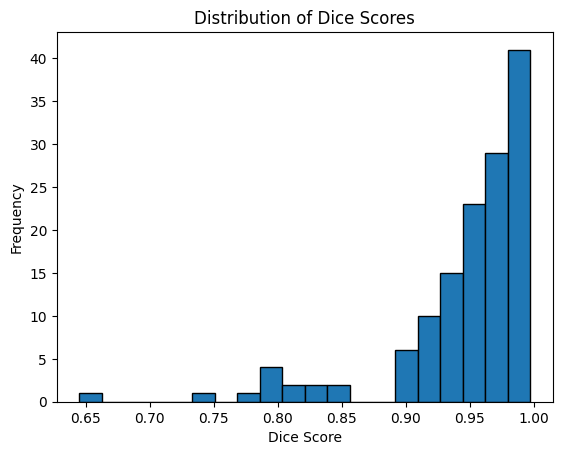

In [53]:
import matplotlib.pyplot as plt
plt.hist(dice_ds['Dice'], bins=20, edgecolor='black')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.title('Distribution of Dice Scores')
plt.show()

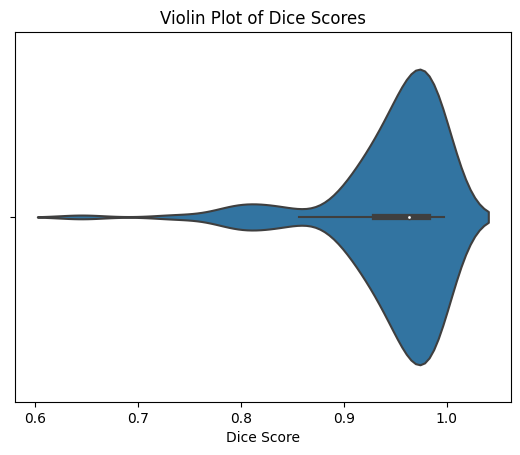

In [54]:
import seaborn as sns

sns.violinplot(x=dice_ds['Dice'])
plt.xlabel('Dice Score')
plt.title('Violin Plot of Dice Scores')
plt.show()

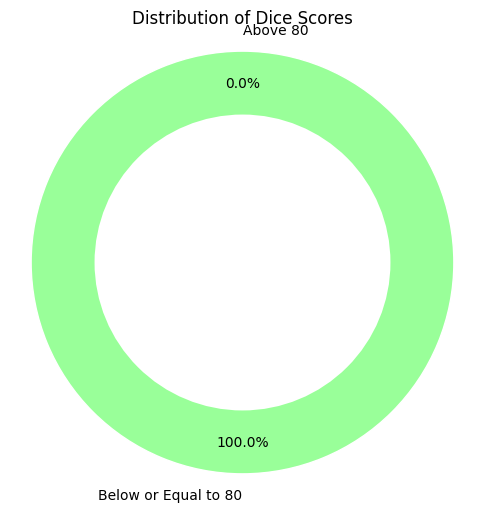

In [64]:
import seaborn as sns

# Count patients with Dice scores above 80 and those below or equal to 80
above_80 = dice_ds[dice_ds['Dice'] > 80].shape[0]
below_80 = dice_ds[dice_ds['Dice'] <= 80].shape[0]

# Data for the pie chart
sizes = [above_80, below_80]
labels = ['Above 80', 'Below or Equal to 80']

# Create the pie chart using Seaborn's donut plot style
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90, pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw circle in the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Dice Scores')
plt.show()

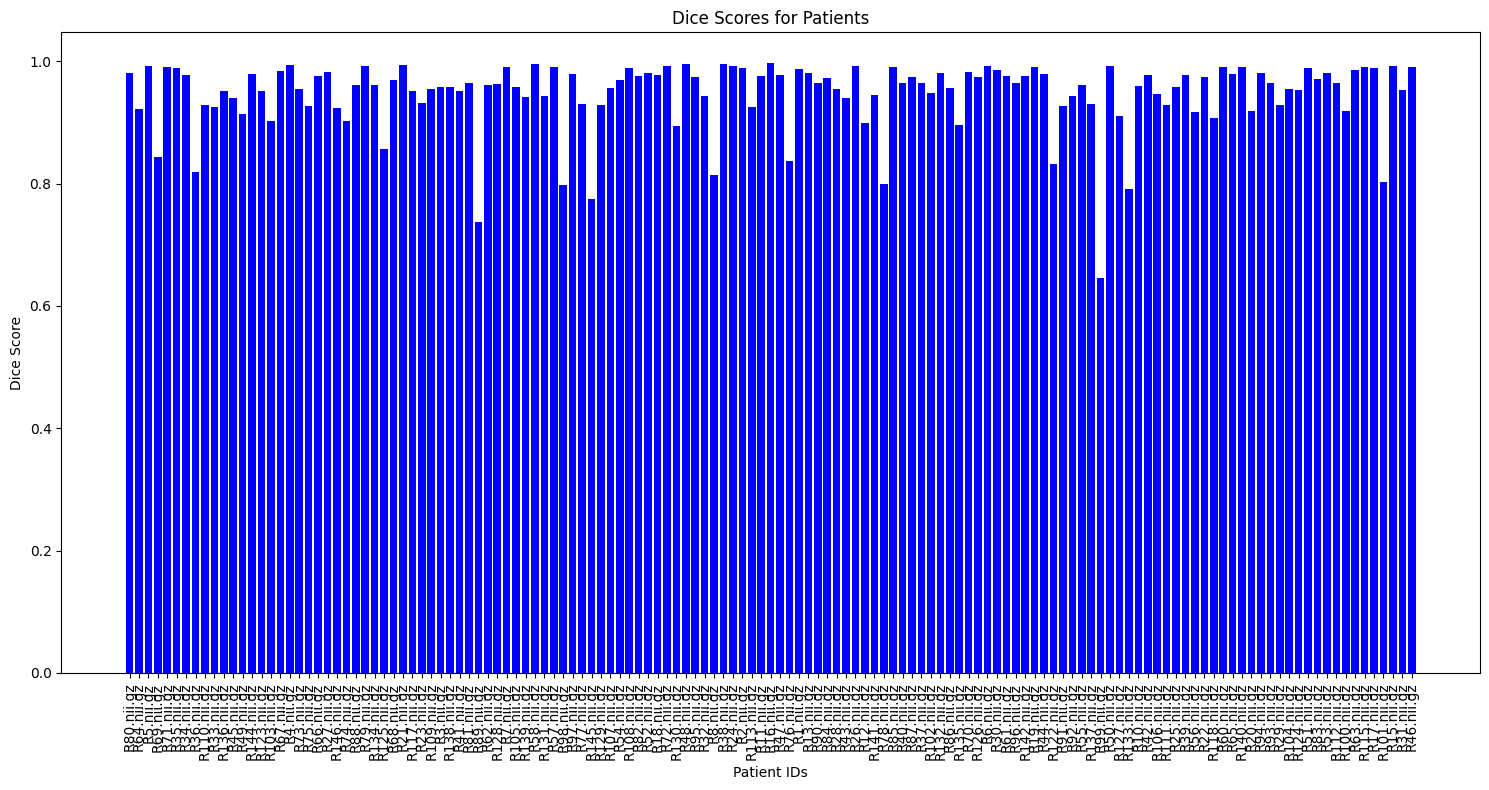

In [57]:
plt.figure(figsize=(15, 8))
plt.bar(dice_ds['Patinet'], dice_ds['Dice'], color='blue')
plt.xlabel('Patient IDs')
plt.ylabel('Dice Score')
plt.title('Dice Scores for Patients')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

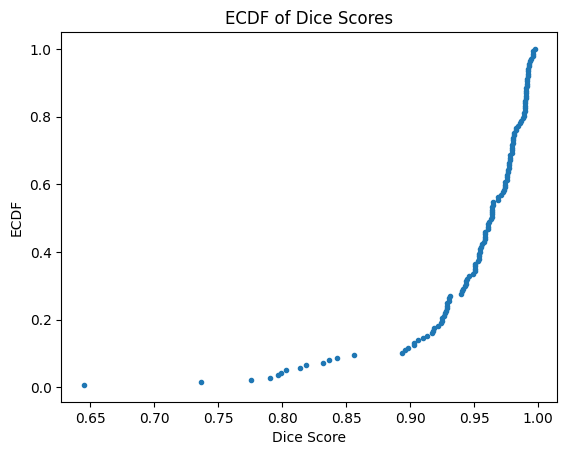

In [56]:
sorted_data = np.sort(dice_ds['Dice'])
yvals = np.arange(1, len(sorted_data)+1) / len(sorted_data)
plt.plot(sorted_data, yvals, marker='.', linestyle='none')
plt.xlabel('Dice Score')
plt.ylabel('ECDF')
plt.title('ECDF of Dice Scores')
plt.show()

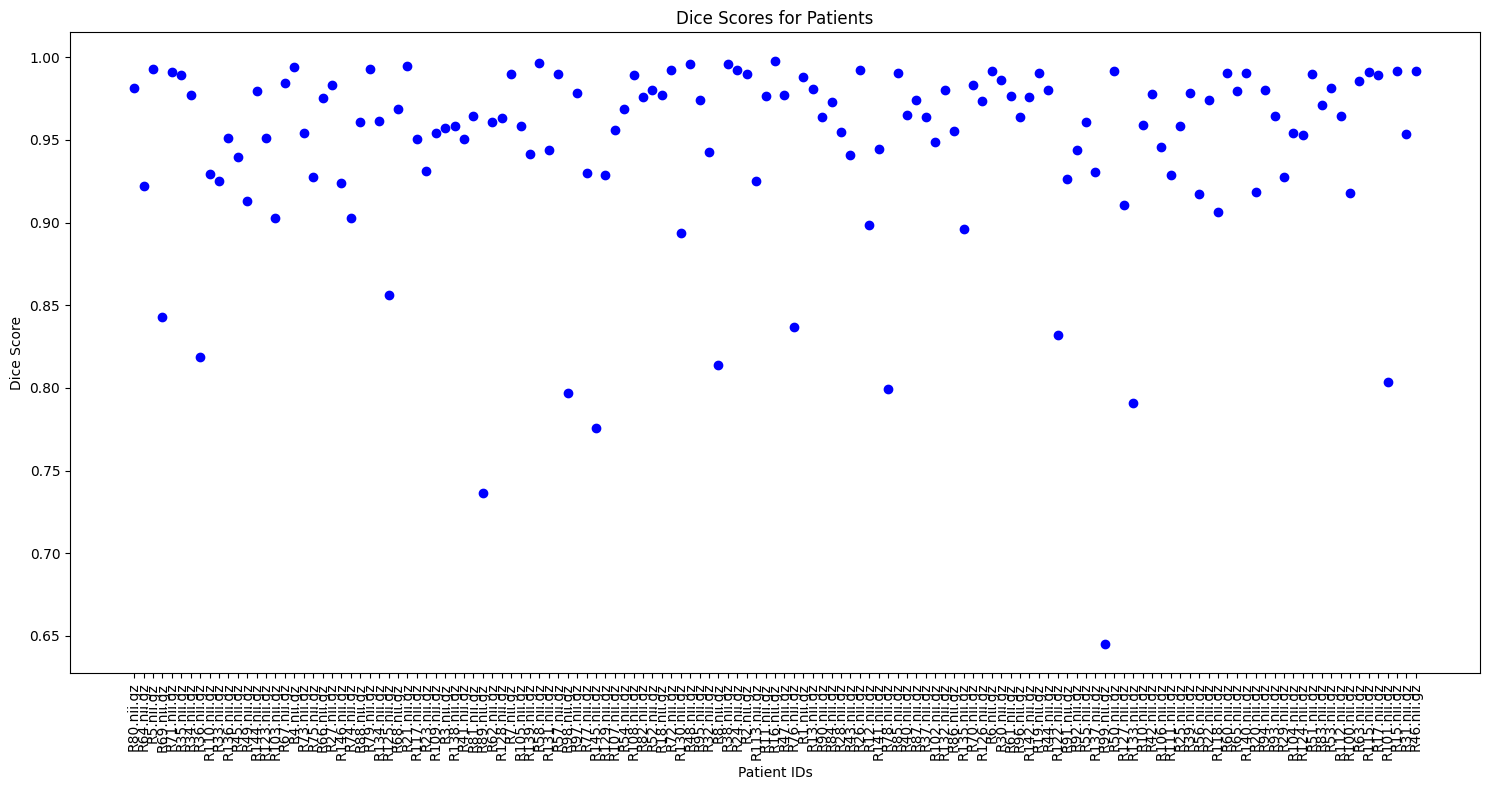

In [59]:
plt.figure(figsize=(15, 8))
plt.scatter(dice_ds['Patinet'], dice_ds['Dice'], color='blue', marker='o')
plt.xlabel('Patient IDs')
plt.ylabel('Dice Score')
plt.title('Dice Scores for Patients')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [38]:
import json
f = open('/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/summary.json')
dice = 0
summary = json.load(f)
for i in range(0,len(summary)):
    # print(summary[str(i)])
    dice += summary[str(i)]['Dice']
print("Average Dice score is:",dice/len(summary))

Average Dice score is: 0.9466519028885784


# Trash Code

#### Evaluation tries

In [15]:
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


import collections
import inspect
import json
import hashlib
from datetime import datetime
from multiprocessing.pool import Pool
import numpy as np
import pandas as pd
import SimpleITK as sitk
from nnunet.evaluation.metrics import ConfusionMatrix, ALL_METRICS
from batchgenerators.utilities.file_and_folder_operations import save_json, subfiles, join
from collections import OrderedDict


class Evaluator:
    """Object that holds test and reference segmentations with label information
    and computes a number of metrics on the two. 'labels' must either be an
    iterable of numeric values (or tuples thereof) or a dictionary with string
    names and numeric values.
    """

    default_metrics = [
        "False Positive Rate",
        "Dice",
        "Jaccard",
        "Precision",
        "Recall",
        "Accuracy",
        "False Omission Rate",
        "Negative Predictive Value",
        "False Negative Rate",
        "True Negative Rate",
        "False Discovery Rate",
        "Total Positives Test",
        "Total Positives Reference"
    ]

    default_advanced_metrics = [
        #"Hausdorff Distance",
        "Hausdorff Distance 95",
        #"Avg. Surface Distance",
        #"Avg. Symmetric Surface Distance"
    ]

    def __init__(self,
                 test=None,
                 reference=None,
                 labels=None,
                 metrics=None,
                 advanced_metrics=None,
                 nan_for_nonexisting=True):

        self.test = None
        self.reference = None
        self.confusion_matrix = ConfusionMatrix()
        self.labels = None
        self.nan_for_nonexisting = nan_for_nonexisting
        self.result = None

        self.metrics = []
        if metrics is None:
            for m in self.default_metrics:
                self.metrics.append(m)
        else:
            for m in metrics:
                self.metrics.append(m)

        self.advanced_metrics = []
        if advanced_metrics is None:
            for m in self.default_advanced_metrics:
                self.advanced_metrics.append(m)
        else:
            for m in advanced_metrics:
                self.advanced_metrics.append(m)

        self.set_reference(reference)
        self.set_test(test)
        if labels is not None:
            self.set_labels(labels)
        else:
            if test is not None and reference is not None:
                self.construct_labels()

    def set_test(self, test):
        """Set the test segmentation."""

        self.test = test

    def set_reference(self, reference):
        """Set the reference segmentation."""

        self.reference = reference

    def set_labels(self, labels):
        """Set the labels.
        :param labels= may be a dictionary (int->str), a set (of ints), a tuple (of ints) or a list (of ints). Labels
        will only have names if you pass a dictionary"""

        if isinstance(labels, dict):
            self.labels = collections.OrderedDict(labels)
        elif isinstance(labels, set):
            self.labels = list(labels)
        elif isinstance(labels, np.ndarray):
            self.labels = [i for i in labels]
        elif isinstance(labels, (list, tuple)):
            self.labels = labels
        else:
            raise TypeError("Can only handle dict, list, tuple, set & numpy array, but input is of type {}".format(type(labels)))

    def construct_labels(self):
        """Construct label set from unique entries in segmentations."""

        if self.test is None and self.reference is None:
            raise ValueError("No test or reference segmentations.")
        elif self.test is None:
            labels = np.unique(self.reference)
        else:
            labels = np.union1d(np.unique(self.test),
                                np.unique(self.reference))
        self.labels = list(map(lambda x: int(x), labels))

    def set_metrics(self, metrics):
        """Set evaluation metrics"""

        if isinstance(metrics, set):
            self.metrics = list(metrics)
        elif isinstance(metrics, (list, tuple, np.ndarray)):
            self.metrics = metrics
        else:
            raise TypeError("Can only handle list, tuple, set & numpy array, but input is of type {}".format(type(metrics)))

    def add_metric(self, metric):

        if metric not in self.metrics:
            self.metrics.append(metric)

    def evaluate(self, test=None, reference=None, advanced=False, **metric_kwargs):
        """Compute metrics for segmentations."""
        if test is not None:
            self.set_test(test)

        if reference is not None:
            self.set_reference(reference)

        if self.test is None or self.reference is None:
            raise ValueError("Need both test and reference segmentations.")

        if self.labels is None:
            self.construct_labels()

        self.metrics.sort()

        # get functions for evaluation
        # somewhat convoluted, but allows users to define additonal metrics
        # on the fly, e.g. inside an IPython console
        _funcs = {m: ALL_METRICS[m] for m in self.metrics + self.advanced_metrics}
        frames = inspect.getouterframes(inspect.currentframe())
        for metric in self.metrics:
            for f in frames:
                if metric in f[0].f_locals:
                    _funcs[metric] = f[0].f_locals[metric]
                    break
            else:
                if metric in _funcs:
                    continue
                else:
                    raise NotImplementedError(
                        "Metric {} not implemented.".format(metric))

        # get results
        self.result = OrderedDict()

        eval_metrics = self.metrics
        if advanced:
            eval_metrics += self.advanced_metrics

        if isinstance(self.labels, dict):

            for label, name in self.labels.items():
                k = str(name)
                self.result[k] = OrderedDict()
                if not hasattr(label, "__iter__"):
                    self.confusion_matrix.set_test(self.test == label)
                    self.confusion_matrix.set_reference(self.reference == label)
                else:
                    current_test = 0
                    current_reference = 0
                    for l in label:
                        current_test += (self.test == l)
                        current_reference += (self.reference == l)
                    self.confusion_matrix.set_test(current_test)
                    self.confusion_matrix.set_reference(current_reference)
                for metric in eval_metrics:
                    self.result[k][metric] = _funcs[metric](confusion_matrix=self.confusion_matrix,
                                                               nan_for_nonexisting=self.nan_for_nonexisting,
                                                               **metric_kwargs)

        else:

            for i, l in enumerate(self.labels):
                k = str(l)
                self.result[k] = OrderedDict()
                self.confusion_matrix.set_test(self.test == l)
                self.confusion_matrix.set_reference(self.reference == l)
                for metric in eval_metrics:
                    self.result[k][metric] = _funcs[metric](confusion_matrix=self.confusion_matrix,
                                                            nan_for_nonexisting=self.nan_for_nonexisting,
                                                            **metric_kwargs)

        return self.result

    def to_dict(self):

        if self.result is None:
            self.evaluate()
        return self.result

    def to_array(self):
        """Return result as numpy array (labels x metrics)."""

        if self.result is None:
            self.evaluate

        result_metrics = sorted(self.result[list(self.result.keys())[0]].keys())

        a = np.zeros((len(self.labels), len(result_metrics)), dtype=np.float32)

        if isinstance(self.labels, dict):
            for i, label in enumerate(self.labels.keys()):
                for j, metric in enumerate(result_metrics):
                    a[i][j] = self.result[self.labels[label]][metric]
        else:
            for i, label in enumerate(self.labels):
                for j, metric in enumerate(result_metrics):
                    a[i][j] = self.result[label][metric]

        return a

    def to_pandas(self):
        """Return result as pandas DataFrame."""

        a = self.to_array()

        if isinstance(self.labels, dict):
            labels = list(self.labels.values())
        else:
            labels = self.labels

        result_metrics = sorted(self.result[list(self.result.keys())[0]].keys())

        return pd.DataFrame(a, index=labels, columns=result_metrics)


class NiftiEvaluator(Evaluator):

    def __init__(self, *args, **kwargs):

        self.test_nifti = None
        self.reference_nifti = None
        super(NiftiEvaluator, self).__init__(*args, **kwargs)

    def set_test(self, test):
        """Set the test segmentation."""

        if test is not None:
            self.test_nifti = sitk.ReadImage(test)
            super(NiftiEvaluator, self).set_test(sitk.GetArrayFromImage(self.test_nifti))
        else:
            self.test_nifti = None
            super(NiftiEvaluator, self).set_test(test)

    def set_reference(self, reference):
        """Set the reference segmentation."""

        if reference is not None:
            self.reference_nifti = sitk.ReadImage(reference)
            super(NiftiEvaluator, self).set_reference(sitk.GetArrayFromImage(self.reference_nifti))
        else:
            self.reference_nifti = None
            super(NiftiEvaluator, self).set_reference(reference)

    def evaluate(self, test=None, reference=None, voxel_spacing=None, **metric_kwargs):

        if voxel_spacing is None:
            voxel_spacing = np.array(self.test_nifti.GetSpacing())[::-1]
            metric_kwargs["voxel_spacing"] = voxel_spacing

        return super(NiftiEvaluator, self).evaluate(test, reference, **metric_kwargs)


def run_evaluation(args):
    test, ref, evaluator, metric_kwargs = args
    # evaluate
    evaluator.set_test(test)
    evaluator.set_reference(ref)
    if evaluator.labels is None:
        evaluator.construct_labels()
    current_scores = evaluator.evaluate(**metric_kwargs)
    if type(test) == str:
        current_scores["test"] = test
    if type(ref) == str:
        current_scores["reference"] = ref
    return current_scores


def aggregate_scores(test_ref_pairs,
                     evaluator=NiftiEvaluator,
                     labels=None,
                     nanmean=True,
                     json_output_file=None,
                     json_name="",
                     json_description="",
                     json_author="Fabian",
                     json_task="",
                     num_threads=2,
                     **metric_kwargs):
    """
    test = predicted image
    :param test_ref_pairs:
    :param evaluator:
    :param labels: must be a dict of int-> str or a list of int
    :param nanmean:
    :param json_output_file:
    :param json_name:
    :param json_description:
    :param json_author:
    :param json_task:
    :param metric_kwargs:
    :return:
    """

    if type(evaluator) == type:
        evaluator = evaluator()

    if labels is not None:
        evaluator.set_labels(labels)

    all_scores = OrderedDict()
    all_scores["all"] = []
    all_scores["mean"] = OrderedDict()

    test = [i[0] for i in test_ref_pairs]
    ref = [i[1] for i in test_ref_pairs]
    p = Pool(num_threads)
    all_res = p.map(run_evaluation, zip(test, ref, [evaluator]*len(ref), [metric_kwargs]*len(ref)))
    p.close()
    p.join()

    for i in range(len(all_res)):
        all_scores["all"].append(all_res[i])

        # append score list for mean
        for label, score_dict in all_res[i].items():
            if label in ("test", "reference"):
                continue
            if label not in all_scores["mean"]:
                all_scores["mean"][label] = OrderedDict()
            for score, value in score_dict.items():
                if score not in all_scores["mean"][label]:
                    all_scores["mean"][label][score] = []
                all_scores["mean"][label][score].append(value)

    for label in all_scores["mean"]:
        for score in all_scores["mean"][label]:
            if nanmean:
                all_scores["mean"][label][score] = float(np.nanmean(all_scores["mean"][label][score]))
            else:
                all_scores["mean"][label][score] = float(np.mean(all_scores["mean"][label][score]))

    # save to file if desired
    # we create a hopefully unique id by hashing the entire output dictionary
    if json_output_file is not None:
        json_dict = OrderedDict()
        json_dict["name"] = json_name
        json_dict["description"] = json_description
        timestamp = datetime.today()
        json_dict["timestamp"] = str(timestamp)
        json_dict["task"] = json_task
        json_dict["author"] = json_author
        json_dict["results"] = all_scores
        json_dict["id"] = hashlib.md5(json.dumps(json_dict).encode("utf-8")).hexdigest()[:12]
        save_json(json_dict, json_output_file)


    return all_scores


def aggregate_scores_for_experiment(score_file,
                                    labels=None,
                                    metrics=Evaluator.default_metrics,
                                    nanmean=True,
                                    json_output_file=None,
                                    json_name="",
                                    json_description="",
                                    json_author="Fabian",
                                    json_task=""):

    scores = np.load(score_file)
    scores_mean = scores.mean(0)
    if labels is None:
        labels = list(map(str, range(scores.shape[1])))

    results = []
    results_mean = OrderedDict()
    for i in range(scores.shape[0]):
        results.append(OrderedDict())
        for l, label in enumerate(labels):
            results[-1][label] = OrderedDict()
            results_mean[label] = OrderedDict()
            for m, metric in enumerate(metrics):
                results[-1][label][metric] = float(scores[i][l][m])
                results_mean[label][metric] = float(scores_mean[l][m])

    json_dict = OrderedDict()
    json_dict["name"] = json_name
    json_dict["description"] = json_description
    timestamp = datetime.today()
    json_dict["timestamp"] = str(timestamp)
    json_dict["task"] = json_task
    json_dict["author"] = json_author
    json_dict["results"] = {"all": results, "mean": results_mean}
    json_dict["id"] = hashlib.md5(json.dumps(json_dict).encode("utf-8")).hexdigest()[:12]
    if json_output_file is not None:
        json_output_file = open(json_output_file, "w")
        json.dump(json_dict, json_output_file, indent=4, separators=(",", ": "))
        json_output_file.close()

    return json_dict


def evaluate_folder(folder_with_gts: str, folder_with_predictions: str, labels: tuple, **metric_kwargs):
    """
    writes a summary.json to folder_with_predictions
    :param folder_with_gts: folder where the ground truth segmentations are saved. Must be nifti files.
    :param folder_with_predictions: folder where the predicted segmentations are saved. Must be nifti files.
    :param labels: tuple of int with the labels in the dataset. For example (0, 1, 2, 3) for Task001_BrainTumour.
    :return:
    """
    files_gt = subfiles(folder_with_gts, suffix=".nii.gz", join=False)
    files_pred = subfiles(folder_with_predictions, suffix=".nii.gz", join=False)
    assert all([i in files_pred for i in files_gt]), "files missing in folder_with_predictions"
    assert all([i in files_gt for i in files_pred]), "files missing in folder_with_gts"
    test_ref_pairs = [(join(folder_with_predictions, i), join(folder_with_gts, i)) for i in files_pred]
    res = aggregate_scores(test_ref_pairs, json_output_file=join(folder_with_predictions, "summary.json"),
                           num_threads=8, labels=labels, **metric_kwargs)
    return res


def nnunet_evaluate_folder():
    import argparse
    parser = argparse.ArgumentParser("Evaluates the segmentations located in the folder pred. Output of this script is "
                                     "a json file. At the very bottom of the json file is going to be a 'mean' "
                                     "entry with averages metrics across all cases")
    parser.add_argument('-ref', required=True, type=str, help="Folder containing the reference segmentations in nifti "
                                                              "format.")
    parser.add_argument('-pred', required=True, type=str, help="Folder containing the predicted segmentations in nifti "
                                                               "format. File names must match between the folders!")
    parser.add_argument('-l', nargs='+', type=int, required=True, help="List of label IDs (integer values) that should "
                                                                       "be evaluated. Best practice is to use all int "
                                                                       "values present in the dataset, so for example "
                                                                       "for LiTS the labels are 0: background, 1: "
                                                                       "liver, 2: tumor. So this argument "
                                                                       "should be -l 1 2. You can if you want also "
                                                                       "evaluate the background label (0) but in "
                                                                       "this case that would not gie any useful "
                                                                       "information.")
    args = parser.parse_args()
    return evaluate_folder(args.ref, args.pred, args.l)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [17]:
import multiprocessing
import os
from copy import deepcopy
from multiprocessing import Pool
from typing import Tuple, List, Union, Optional

import numpy as np
from batchgenerators.utilities.file_and_folder_operations import subfiles, join, save_json, load_json, \
    isfile
from nnunetv2.configuration import default_num_processes
from nnunetv2.imageio.base_reader_writer import BaseReaderWriter
from nnunetv2.imageio.reader_writer_registry import determine_reader_writer_from_dataset_json, \
    determine_reader_writer_from_file_ending
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
# the Evaluator class of the previous nnU-Net was great and all but man was it overengineered. Keep it simple
from nnunetv2.utilities.json_export import recursive_fix_for_json_export
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager


def label_or_region_to_key(label_or_region: Union[int, Tuple[int]]):
    return str(label_or_region)


def key_to_label_or_region(key: str):
    try:
        return int(key)
    except ValueError:
        key = key.replace('(', '')
        key = key.replace(')', '')
        splitted = key.split(',')
        return tuple([int(i) for i in splitted])


def save_summary_json(results: dict, output_file: str):
    """
    stupid json does not support tuples as keys (why does it have to be so shitty) so we need to convert that shit
    ourselves
    """
    results_converted = deepcopy(results)
    # convert keys in mean metrics
    results_converted['mean'] = {label_or_region_to_key(k): results['mean'][k] for k in results['mean'].keys()}
    # convert metric_per_case
    for i in range(len(results_converted["metric_per_case"])):
        results_converted["metric_per_case"][i]['metrics'] = \
            {label_or_region_to_key(k): results["metric_per_case"][i]['metrics'][k]
             for k in results["metric_per_case"][i]['metrics'].keys()}
    # sort_keys=True will make foreground_mean the first entry and thus easy to spot
    save_json(results_converted, output_file, sort_keys=True)


def load_summary_json(filename: str):
    results = load_json(filename)
    # convert keys in mean metrics
    results['mean'] = {key_to_label_or_region(k): results['mean'][k] for k in results['mean'].keys()}
    # convert metric_per_case
    for i in range(len(results["metric_per_case"])):
        results["metric_per_case"][i]['metrics'] = \
            {key_to_label_or_region(k): results["metric_per_case"][i]['metrics'][k]
             for k in results["metric_per_case"][i]['metrics'].keys()}
    return results


def labels_to_list_of_regions(labels: List[int]):
    return [(i,) for i in labels]


def region_or_label_to_mask(segmentation: np.ndarray, region_or_label: Union[int, Tuple[int, ...]]) -> np.ndarray:
    if np.isscalar(region_or_label):
        return segmentation == region_or_label
    else:
        mask = np.zeros_like(segmentation, dtype=bool)
        for r in region_or_label:
            mask[segmentation == r] = True
    return mask


def compute_tp_fp_fn_tn(mask_ref: np.ndarray, mask_pred: np.ndarray, ignore_mask: np.ndarray = None):
    if ignore_mask is None:
        use_mask = np.ones_like(mask_ref, dtype=bool)
    else:
        use_mask = ~ignore_mask
    tp = np.sum((mask_ref & mask_pred) & use_mask)
    fp = np.sum(((~mask_ref) & mask_pred) & use_mask)
    fn = np.sum((mask_ref & (~mask_pred)) & use_mask)
    tn = np.sum(((~mask_ref) & (~mask_pred)) & use_mask)
    return tp, fp, fn, tn


def compute_metrics(reference_file: str, prediction_file: str, image_reader_writer: BaseReaderWriter,
                    labels_or_regions: Union[List[int], List[Union[int, Tuple[int, ...]]]],
                    ignore_label: int = None) -> dict:
    # load images
    seg_ref, seg_ref_dict = image_reader_writer.read_seg(reference_file)
    seg_pred, seg_pred_dict = image_reader_writer.read_seg(prediction_file)
    # spacing = seg_ref_dict['spacing']

    ignore_mask = seg_ref == ignore_label if ignore_label is not None else None

    results = {}
    results['reference_file'] = reference_file
    results['prediction_file'] = prediction_file
    results['metrics'] = {}
    for r in labels_or_regions:
        results['metrics'][r] = {}
        mask_ref = region_or_label_to_mask(seg_ref, r)
        mask_pred = region_or_label_to_mask(seg_pred, r)
        tp, fp, fn, tn = compute_tp_fp_fn_tn(mask_ref, mask_pred, ignore_mask)
        if tp + fp + fn == 0:
            results['metrics'][r]['Dice'] = np.nan
            results['metrics'][r]['IoU'] = np.nan
        else:
            results['metrics'][r]['Dice'] = 2 * tp / (2 * tp + fp + fn)
            results['metrics'][r]['IoU'] = tp / (tp + fp + fn)
        results['metrics'][r]['FP'] = fp
        results['metrics'][r]['TP'] = tp
        results['metrics'][r]['FN'] = fn
        results['metrics'][r]['TN'] = tn
        results['metrics'][r]['n_pred'] = fp + tp
        results['metrics'][r]['n_ref'] = fn + tp
    return results


def compute_metrics_on_folder(folder_ref: str, folder_pred: str, output_file: str,
                              image_reader_writer: BaseReaderWriter,
                              file_ending: str,
                              regions_or_labels: Union[List[int], List[Union[int, Tuple[int, ...]]]],
                              ignore_label: int = None,
                              num_processes: int = default_num_processes,
                              chill: bool = True) -> dict:
    """
    output_file must end with .json; can be None
    """
    if output_file is not None:
        assert output_file.endswith('.json'), 'output_file should end with .json'
    files_pred = subfiles(folder_pred, suffix=file_ending, join=False)
    files_ref = subfiles(folder_ref, suffix=file_ending, join=False)
    if not chill:
        present = [isfile(join(folder_pred, i)) for i in files_ref]
        assert all(present), "Not all files in folder_pred exist in folder_ref"
    files_ref = [join(folder_ref, i) for i in files_pred]
    files_pred = [join(folder_pred, i) for i in files_pred]
    with multiprocessing.get_context("spawn").Pool(num_processes) as pool:
        # for i in list(zip(files_ref, files_pred, [image_reader_writer] * len(files_pred), [regions_or_labels] * len(files_pred), [ignore_label] * len(files_pred))):
        #     compute_metrics(*i)
        results = pool.starmap(
            compute_metrics,
            list(zip(files_ref, files_pred, [image_reader_writer] * len(files_pred), [regions_or_labels] * len(files_pred),
                     [ignore_label] * len(files_pred)))
        )

    # mean metric per class
    metric_list = list(results[0]['metrics'][regions_or_labels[0]].keys())
    means = {}
    for r in regions_or_labels:
        means[r] = {}
        for m in metric_list:
            means[r][m] = np.nanmean([i['metrics'][r][m] for i in results])

    # foreground mean
    foreground_mean = {}
    for m in metric_list:
        values = []
        for k in means.keys():
            if k == 0 or k == '0':
                continue
            values.append(means[k][m])
        foreground_mean[m] = np.mean(values)

    [recursive_fix_for_json_export(i) for i in results]
    recursive_fix_for_json_export(means)
    recursive_fix_for_json_export(foreground_mean)
    result = {'metric_per_case': results, 'mean': means, 'foreground_mean': foreground_mean}
    if output_file is not None:
        save_summary_json(result, output_file)
    return result
    # print('DONE')


def compute_metrics_on_folder2(folder_ref: str, folder_pred: str, dataset_json_file: str, plans_file: str,
                               output_file: str = None,
                               num_processes: int = default_num_processes,
                               chill: bool = False):
    dataset_json = load_json(dataset_json_file)
    # get file ending
    file_ending = dataset_json['file_ending']

    # get reader writer class
    example_file = subfiles(folder_ref, suffix=file_ending, join=True)[0]
    rw = determine_reader_writer_from_dataset_json(dataset_json, example_file)()

    # maybe auto set output file
    if output_file is None:
        output_file = join(folder_pred, 'summary.json')

    lm = PlansManager(plans_file).get_label_manager(dataset_json)
    compute_metrics_on_folder(folder_ref, folder_pred, output_file, rw, file_ending,
                              lm.foreground_regions if lm.has_regions else lm.foreground_labels, lm.ignore_label,
                              num_processes, chill=chill)


def compute_metrics_on_folder_simple(folder_ref: str, folder_pred: str, labels: Union[Tuple[int, ...], List[int]],
                                     output_file: str = None,
                                     num_processes: int = default_num_processes,
                                     ignore_label: int = None,
                                     chill: bool = False):
    example_file = subfiles(folder_ref, join=True)[0]
    file_ending = os.path.splitext(example_file)[-1]
    rw = determine_reader_writer_from_file_ending(file_ending, example_file, allow_nonmatching_filename=True,
                                                  verbose=False)()
    # maybe auto set output file
    if output_file is None:
        output_file = join(folder_pred, 'summary.json')
    compute_metrics_on_folder(folder_ref, folder_pred, output_file, rw, file_ending,
                              labels, ignore_label=ignore_label, num_processes=num_processes, chill=chill)


def evaluate_folder_entry_point():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('gt_folder', type=str, help='folder with gt segmentations')
    parser.add_argument('pred_folder', type=str, help='folder with predicted segmentations')
    parser.add_argument('-djfile', type=str, required=True,
                        help='dataset.json file')
    parser.add_argument('-pfile', type=str, required=True,
                        help='plans.json file')
    parser.add_argument('-o', type=str, required=False, default=None,
                        help='Output file. Optional. Default: pred_folder/summary.json')
    parser.add_argument('-np', type=int, required=False, default=default_num_processes,
                        help=f'number of processes used. Optional. Default: {default_num_processes}')
    parser.add_argument('--chill', action='store_true', help='dont crash if folder_pred doesnt have all files that are present in folder_gt')
    args = parser.parse_args()
    compute_metrics_on_folder2(args.gt_folder, args.pred_folder, args.djfile, args.pfile, args.o, args.np, chill=args.chill)


def evaluate_simple_entry_point():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('gt_folder', type=str, help='folder with gt segmentations')
    parser.add_argument('pred_folder', type=str, help='folder with predicted segmentations')
    parser.add_argument('-l', type=int, nargs='+', required=True,
                        help='list of labels')
    parser.add_argument('-il', type=int, required=False, default=None,
                        help='ignore label')
    parser.add_argument('-o', type=str, required=False, default=None,
                        help='Output file. Optional. Default: pred_folder/summary.json')
    parser.add_argument('-np', type=int, required=False, default=default_num_processes,
                        help=f'number of processes used. Optional. Default: {default_num_processes}')
    parser.add_argument('--chill', action='store_true', help='dont crash if folder_pred doesnt have all files that are present in folder_gt')

    args = parser.parse_args()
    compute_metrics_on_folder_simple(args.gt_folder, args.pred_folder, args.l, args.o, args.np, args.il, chill=args.chill)

# if __name__ == '__main__':
#         folder_ref = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT'
#         folder_pred = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred'
#         output_file = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred/summary.json'
#         image_reader_writer = SimpleITKIO()
#         file_ending = '.nii.gz'
#         regions = labels_to_list_of_regions(labels)
#         ignore_label = None
#         num_processes = 8
#         compute_metrics_on_folder(folder_ref, folder_pred, output_file, image_reader_writer, file_ending, regions, ignore_label,
#                                 num_processes)

In [23]:
# if __name__ == '__main__':
#     folder_ref = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT'
#     folder_pred = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred'
#     output_file = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred/summary.json'
#     image_reader_writer = SimpleITKIO()
#     file_ending = '.nii.gz'
#     regions = labels_to_list_of_regions([1, 2])
#     ignore_label = None
#     num_processes = 12
#     compute_metrics_on_folder(folder_ref, folder_pred, output_file, image_reader_writer, file_ending, regions, ignore_label,
#                               num_processes)

In [89]:
patients = ['R01-033']

In [91]:
folder_with_predictions = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred/'
folder_with_gts = '/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/'
for patient in patients:
    copy_files_for_evaluation(patient)
    labels = []
    file = os.listdir("/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/")
    path = "/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/" + file[0]
    print(path)
    in_image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(in_image)
    for i in range(0,len(image)):
        labels.append(i)
    # evaluate_folder(folder_with_gts=folder_with_gts,folder_with_predictions=folder_with_predictions,labels=labels)

/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/R33.nii.gz


(300, 512, 512)


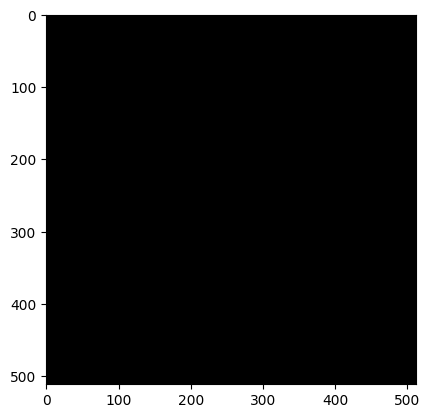

In [93]:
mask_1 = sitk.ReadImage("/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/GT/R33.nii.gz")
mask_1 = sitk.GetArrayFromImage(mask_1)
print(mask_1.shape)
mask_1[:,:,0]
plt.imshow(mask_1[0],cmap = 'gray')

(300, 512, 512)


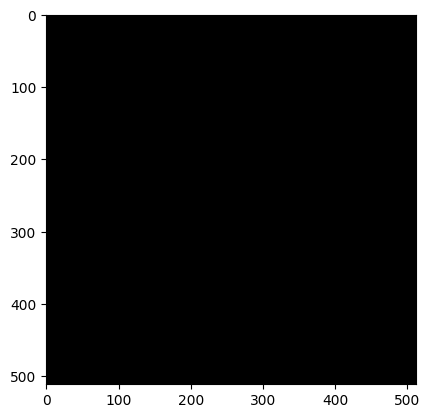

In [94]:
mask_2  = sitk.ReadImage("/home/hrehman/code/DeepLearning/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/evaluation/pred/R33.nii.gz")
mask_2 = sitk.GetArrayFromImage(mask_2)
mask_2[:,:,103]
print(mask_2.shape)
plt.imshow(mask_2[0],cmap = 'gray')

In [109]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2. * intersect ) / (fsum + ssum)
    # dice = np.mean(dice)
    # dice = round(dice, 3) # for easy reading
    return dice  

In [110]:
DICE_COE(mask_1[0], mask_2[0])

/tmp/ipykernel_3282676/2791366069.py:5: RuntimeWarning: invalid value encountered in double_scalars
  dice = (2. * intersect ) / (fsum + ssum)


nan

In [128]:
dice = []
for i in range(len(mask_1)):
    if (np.count_nonzero(mask_1[i]) != 0 or np.count_nonzero(mask_2[i]) != 0):
            print("non zero indexes" , i)
            dice.append(DICE_COE(mask1=mask_1[i] , mask2=mask_2[i]))
np.mean(dice)

non zero indexes 103
non zero indexes 104
non zero indexes 105
non zero indexes 106
non zero indexes 107
non zero indexes 108
non zero indexes 133
non zero indexes 134
non zero indexes 135
non zero indexes 136
non zero indexes 137
non zero indexes 138
non zero indexes 139
non zero indexes 140
non zero indexes 141
non zero indexes 142
non zero indexes 143
non zero indexes 144
non zero indexes 145
non zero indexes 146
non zero indexes 147
non zero indexes 148
non zero indexes 149
non zero indexes 150
non zero indexes 151
non zero indexes 152
non zero indexes 153
non zero indexes 154
non zero indexes 155
non zero indexes 156
non zero indexes 157
non zero indexes 158
non zero indexes 159


0.31787479609539326

In [132]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(y_true, y_pred):
    # y_true = y_true.flatten()
    # y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[index,:,:], y_pred[index,:,:])
    return dice/numLabels

In [101]:
mask_1.shape

(300, 512, 512)

In [133]:
dice_coef_multilabel(mask_1,mask_2,mask_2.shape[0])

0.9249663335202918

In [130]:
compute_dice(mask_1, mask_1, mode='3d', label=1, zboundaries=False)

NotImplementedError: multi-dimensional sub-views are not implemented